In [79]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Load the U.S. Population dataset
df = pd.read_csv('uspopulation.csv', index_col = 'DATE', parse_dates = True)
df.index.freq = 'MS'

In [2]:
df

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699
...,...
2018-08-01,327698
2018-09-01,327893
2018-10-01,328077


## Plot the source data

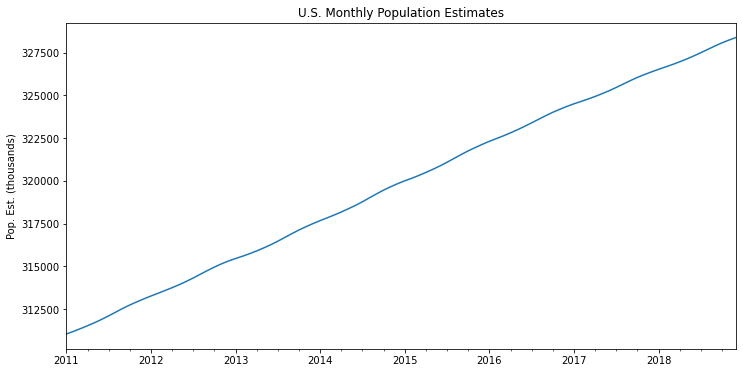

In [6]:
title = 'U.S. Monthly Population Estimates'
ylabel = 'Pop. Est. (thousands)'
xlabel = ''

ax = df['PopEst'].plot(figsize = (12, 6), title = title)
ax.set(xlabel = xlabel, ylabel = ylabel);

## Split the data into train/test sets

In [4]:
len(df)

96

In [7]:
# Set one year for testing
train = df.iloc[:84]
test = df.iloc[84:]

## Fit an AR(1) Model

In [18]:
model = AutoReg(train['PopEst'], lags = 1)
AR1fit = model.fit()
print(f'Lag: {AR1fit.ar_lags}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: [1]
Coefficients:
const        284.913797
PopEst.L1      0.999686
dtype: float64


In [19]:
# This is the general format for obtaining predictions
start = len(train)
end = len(df) - 1
predictions1 = AR1fit.predict(start = start, end = end).rename('AR(1) Predictions')

In [20]:
start, end

(84, 95)

In [21]:
predictions1

2018-01-01    326560.403377
2018-02-01    326742.749463
2018-03-01    326925.038278
2018-04-01    327107.269838
2018-05-01    327289.444162
2018-06-01    327471.561268
2018-07-01    327653.621173
2018-08-01    327835.623896
2018-09-01    328017.569455
2018-10-01    328199.457868
2018-11-01    328381.289152
2018-12-01    328563.063326
Freq: MS, Name: AR(1) Predictions, dtype: float64

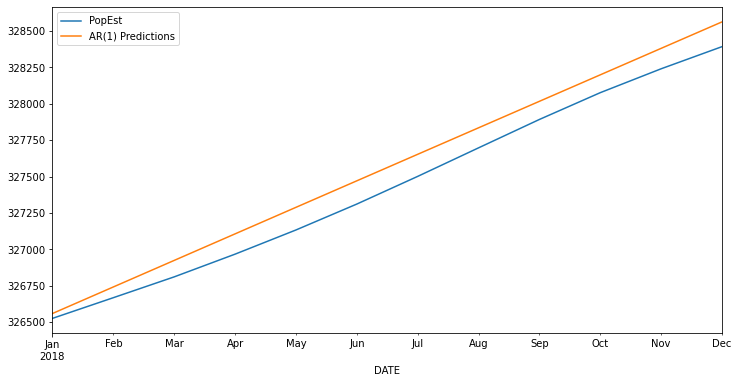

In [24]:
test['PopEst'].plot(legend = True)
predictions1.plot(legend = True, figsize = (12, 6));

## Fit an AR(2) Model

In [26]:
model = AutoReg(train['PopEst'], lags = 2)
AR2fit = model.fit()
print(f'Lag: {AR2fit.ar_lags}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: [1, 2]
Coefficients:
const        137.368305
PopEst.L1      1.853490
PopEst.L2     -0.853836
dtype: float64


In [27]:
start = len(train)
end = len(df) - 1
predictions2 = AR2fit.predict(start = start, end = end, dynamic = False).rename('AR(2) Predictions')

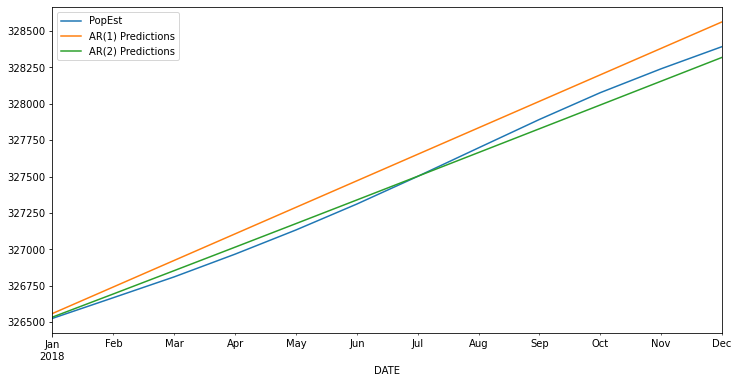

In [28]:
test['PopEst'].plot(legend = True)
predictions1.plot(legend = True)
predictions2.plot(legend = True, figsize = (12, 6));

## Fit an AR(p) model where statsmodels chooses p

In [123]:
search = ar_select_order(train['PopEst'], maxlag = 10, ic = 'aic', glob = True)
search.ar_lags

[1, 2, 3, 4, 7, 10]

In [116]:
model = AutoReg(train['PopEst'], lags = [1, 2, 3, 4, 7, 10])
AR10fit = model.fit()

In [118]:
print(f'Coefficients:\n{AR10fit.params}')

Coefficients:
const         94.210845
PopEst.L1      2.249602
PopEst.L2     -1.808932
PopEst.L3      0.894602
PopEst.L4     -0.478960
PopEst.L7      0.254693
PopEst.L10    -0.111260
dtype: float64


In [119]:
start = len(train)
end = len(df) - 1
rename = f'AR(10) Predictions'

predictions10 = AR10fit.predict(start = start, end = end, dynamic = False).rename(rename)

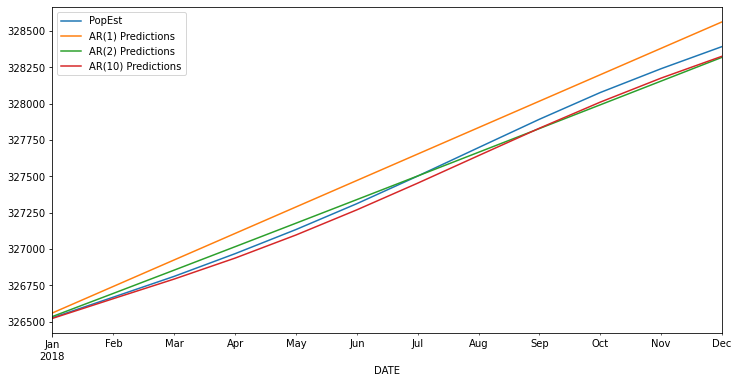

In [120]:
test['PopEst'].plot(legend = True)
predictions1.plot(legend = True)
predictions2.plot(legend = True)
predictions10.plot(legend = True, figsize = (12, 6));

## Evaluate the Model

In [124]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(10)']
preds = [predictions1, predictions2, predictions10]

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 17449.71424
AR(2) Error: 2713.258616
AR(10) Error: 2231.104567


In [122]:
test['PopEst'].mean()

327435.5

In [97]:
modls = [AR1fit, AR2fit, AR10fit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 767.64
AR(2) AIC: 649.21
AR(10) AIC: 466.52


## Forecasting

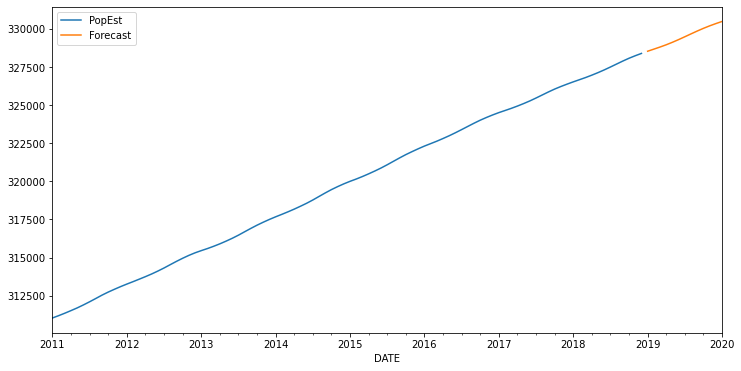

In [125]:
# First, retrain the model on the full dataset
model = AutoReg(df['PopEst'], lags = [1, 2, 3, 4, 7, 10])

# Next, fit the model
ARfit = model.fit()

# Make predictions
forecast = ARfit.predict(start = len(df), end = len(df) + 12, dynamic = False).rename('Forecast')

# Plot the results
df['PopEst'].plot(legend = True)
forecast.plot(legend = True, figsize = (12, 6));